In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from file_process import process_genre_folder,add_tfidf_features,debug_tfidf_features
import pandas as pd
from scipy.stats import pearsonr
import umap
from sklearn.preprocessing import StandardScaler
from scipy.stats import t




c:\Users\Administrator\anaconda3\envs\lingu\lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


ModuleNotFoundError: No module named 'umap'

In [25]:
chinese_path = "../data/chinese"  # ← Change to your folder path
english_path = "../data/english"

chinese_df = process_genre_folder(chinese_path,lang="ch")
english_df = process_genre_folder(english_path,lang="en")


Processing genre: history_fiction
  Success: 5. 步步生莲 (月关) (Z-Library).txt                       → 1,790,461 words
  Success: 3. 隋乱 (酒徒) (Z-Library).txt                         → 1,170,142 words
  Success: 2. 风起陇西 (马伯庸 [马伯庸]) (Z-Library).txt                → 142,867 words
  Success: 4. 新宋 (阿越) (Z-Library).txt                         → 1,738,158 words
  Success: 10. 历史的裂变：中国历史上的十三场政变（畅销书《大唐兴亡三百年》作者王觉仁力作，用小说笔法，讲述 → 143,503 words
  Success: 9. 辛亥：计划外革命 (雪珥) (Z-Library).txt                   → 85,673 words
  Success: 6. 宰执天下 (cuslaa) (Z-Library).txt                   → 3,852,110 words
  Success: 8. 四时歌：骑桶人自选集 (骑桶人) (Z-Library).txt                → 149,371 words
  Success: 7. 窃明 (灰熊猫) (Z-Library).txt                        → 706,476 words
  Success: 1. 长安十二时辰 (马伯庸) (Z-Library).txt                    → 237,443 words

Processing genre: horror
  Success: 5. 奇门遁甲 (周德东) (Z-Library).txt                      → 83,831 words
  Success: 7. 周德东恐怖悬疑小说合集 (周德东) (Z-Library).txt               → 2,909,210 w

In [ ]:
#add tfidf for each df
tf_ch_df = add_tfidf_features(chinese_df,chinese_path)
tf_en_df = add_tfidf_features(english_df,english_path)

In [32]:
#apply normalization
features = ["pronoun_ratio","info_density","avg_sent_len","tfidf_avg"]	
ch_no = tf_ch_df[features].values
ch_no = (ch_no - ch_no.mean(axis=0)) / ch_no.std(axis=0)   # ← THIS IS THE NORMALIZATION
en_no = tf_en_df[features].values
en_no = (en_no - en_no.mean(axis=0)) / en_no.std(axis=0)   # ← THIS IS THE NORMALIZATION

In [35]:
pro_ch_df = tf_ch_df
# Give normalized values back to df
for i, col in enumerate(features):
    pro_ch_df[f"{col}"] = ch_no[:, i]

In [36]:
pro_en_df = tf_en_df
# Give normalized values back to df
for i, col in enumerate(features):
    pro_en_df[f"{col}"] = en_no[:, i]

In [37]:
df = pd.concat([pro_en_df, pro_ch_df], ignore_index=True)

In [38]:
# pca_df = df.dropna(subset=["pronoun_ratio", "info_density", "avg_sent_len","tfidf_avg"]).reset_index(drop=True)

# Now PCA will work perfectly
pca_X = df[features]

In [39]:
pca_X

,pronoun_ratio,info_density,avg_sent_len,tfidf_avg
0,-0.130340,0.107400,-0.547247,-1.062238
1,1.472748,0.612350,-0.693430,-0.682683
2,-1.308206,-0.456095,-0.100420,0.418602
3,0.691650,-0.134843,0.320977,0.041322
4,0.889461,-0.272154,0.456338,-0.073947
...,...,...,...,...
62,1.696003,-1.511967,-0.554985,0.262656
63,0.529281,-0.033544,-0.736333,-1.101471
64,1.157645,-1.405816,-0.491059,0.204537
65,1.302205,-0.423448,-1.042399,1.722720


/home/ubuntu-user/anaconda3/envs/lingu/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


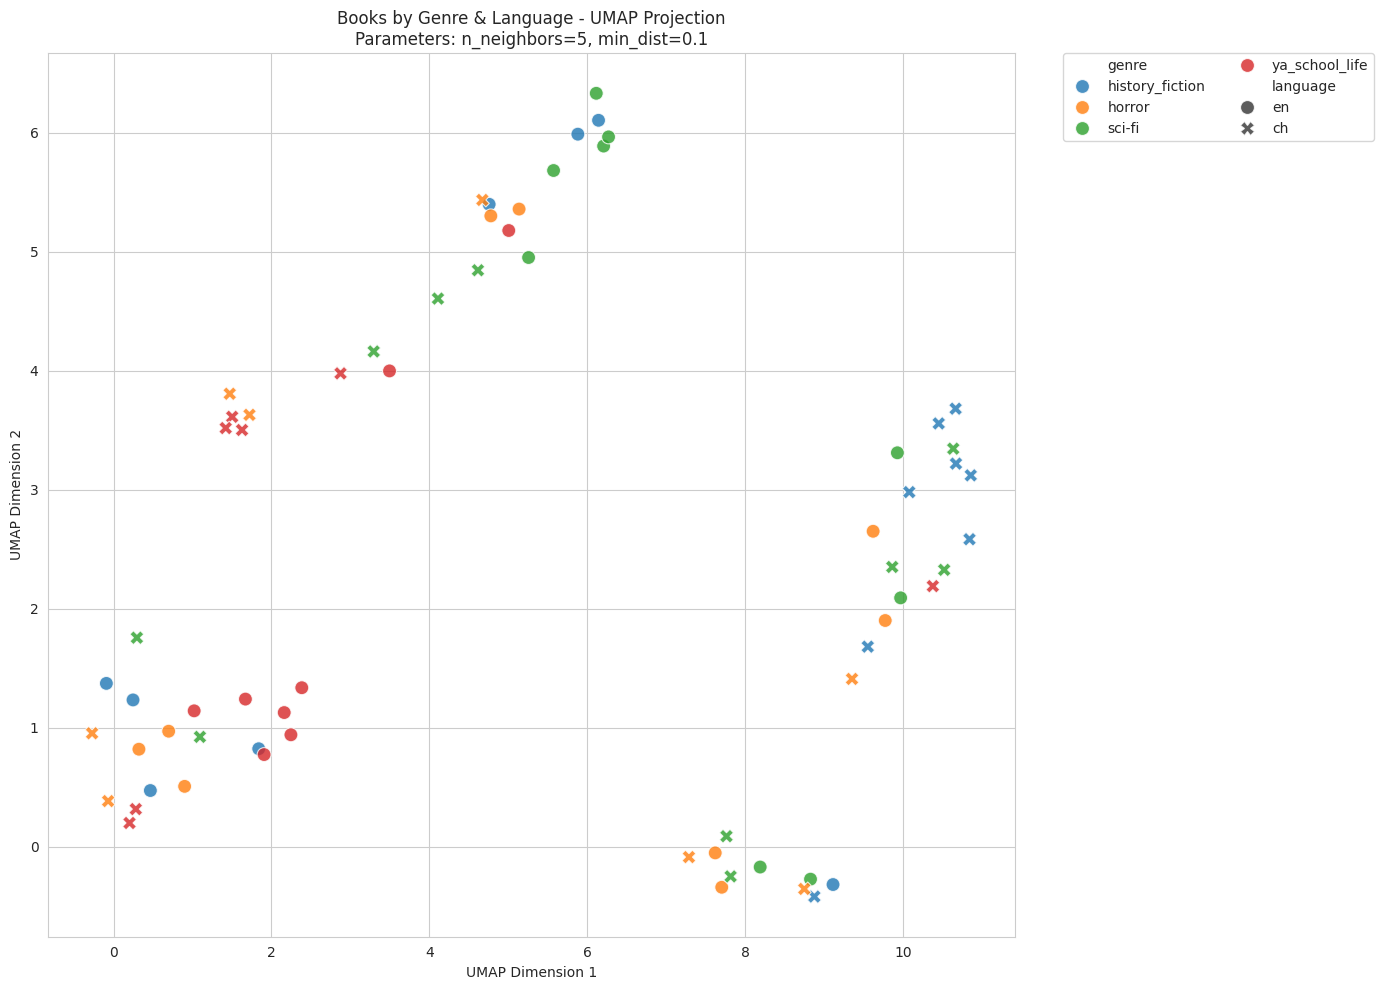

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_X)

# Choose the best looking visualization and apply it to your main dataframe
best_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=5,  # Adjust based on what looked best
    min_dist=0.1,    # Adjust based on what looked best
    random_state=42,
    metric='euclidean'
)

final_umap = best_reducer.fit_transform(X_scaled)
df["umap1"] = final_umap[:, 0]
df["umap2"] = final_umap[:, 1]

# Use categorical palette with maximum contrast
if len(df['genre'].unique()) <= 10:
    palette = "tab10"  # 10 distinct colors
elif len(df['genre'].unique()) <= 20:
    palette = "tab20"  # 20 distinct colors
else:
    palette = "gist_ncar"  # Many distinct color
# Final visualization with both color and style
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df,
    x="umap1", y="umap2",
    hue="genre",
    style="language",
    s=100,
    alpha=0.8,
    palette=palette
)

plt.title(f"Books by Genre & Language - UMAP Projection\n"
          f"Parameters: n_neighbors={best_reducer.n_neighbors}, min_dist={best_reducer.min_dist}")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# Move legend outside
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    ncol=2 if len(df['language'].unique()) > 1 else 1
)

plt.tight_layout()
plt.show()

# Save final results
df.to_csv("analysis_with_umap_final.csv", index=False)


PEARSON CORRELATION: English vs Chinese Stylistic Similarity (by Genre)
             genre  n_en  n_zh  pearson_r  p_value  significant
1           horror     9     8     0.5512   0.4488        False
3   ya_school_life     8     7     0.4042   0.5958        False
0  history_fiction     8     8     0.2206   0.7794        False
2           sci-fi     9    10    -0.5040   0.4960        False

Strong cross-language similarity (r > 0.7):
Empty DataFrame
Columns: [genre, pearson_r, n_en, n_zh]
Index: []


Text(0.5, 1.0, 'How Similar Are English & Chinese Books in the Same Genre?\nHigher r = More similar stylistic profile')

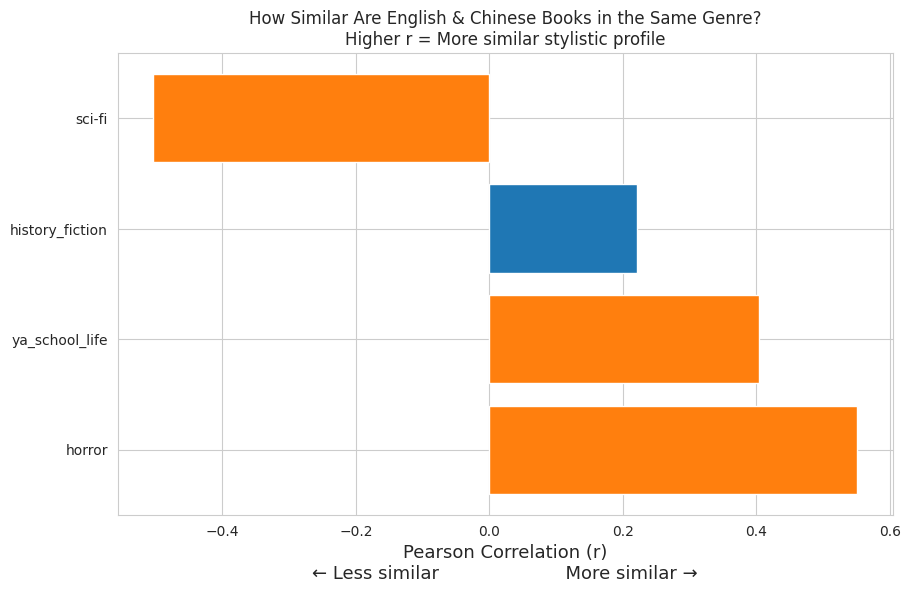

In [ ]:
# ────────────────────────
# 1. Normalize the 3 features (same as before)
# ────────────────────────
features = ["pronoun_ratio", "info_density", "avg_sent_len","tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

X = df[features].values


# ────────────────────────
# 2. Pearson correlation: EN vs ZH within same genre
# ────────────────────────
results = []

for genre in df["genre"].unique():
    en_books = df[(df["genre"] == genre) & (df["language"] == "en")][features]
    zh_books = df[(df["genre"] == genre) & (df["language"] == "ch")][features]
    
    if len(en_books) < 2 or len(zh_books) < 2:
        print(f"Skipping {genre}: not enough books (EN={len(en_books)}, CH={len(zh_books)})")
        continue
    
    # Average stylistic profile per language
    en_mean = en_books.mean()
    zh_mean = zh_books.mean()
    
    # Pearson correlation between the two average vectors
    r, p = pearsonr(en_mean, zh_mean)
    
    results.append({
        "genre": genre,
        "n_en": len(en_books),
        "n_zh": len(zh_books),
        "pearson_r": r,
        "p_value": p,
        "significant": p < 0.05
    })

# Convert to DataFrame
corr_df = pd.DataFrame(results)
corr_df = corr_df.sort_values("pearson_r", ascending=False)

# ────────────────────────
# 3. Display results
# ────────────────────────
print("\nPEARSON CORRELATION: English vs Chinese Stylistic Similarity (by Genre)")
print("="*80)
print(corr_df.round(4))

# Highlight strong similarity
print("\nStrong cross-language similarity (r > 0.7):")
print(corr_df[corr_df["pearson_r"] > 0.7][["genre", "pearson_r", "n_en", "n_zh"]])

# ────────────────────────
# 4. Beautiful bar plot
# ────────────────────────
plt.figure(figsize=(10, 6))
bars = plt.barh(corr_df["genre"], corr_df["pearson_r"], 
                color=np.where(abs(corr_df["pearson_r"]) > 0.7, "#d62728", 
                       np.where(abs(corr_df["pearson_r"]) > 0.4, "#ff7f0e", "#1f77b4")))

plt.xlabel("Pearson Correlation (r)\n← Less similar                      More similar →", fontsize=13)
plt.title("How Similar Are English & Chinese Books in the Same Genre?\n"
          "Higher r = More similar stylistic profile")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27128\1257014804.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27128\1257014804.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27128\1257014804.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27128\1257014804.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


<Figure size 1600x1200 with 0 Axes>

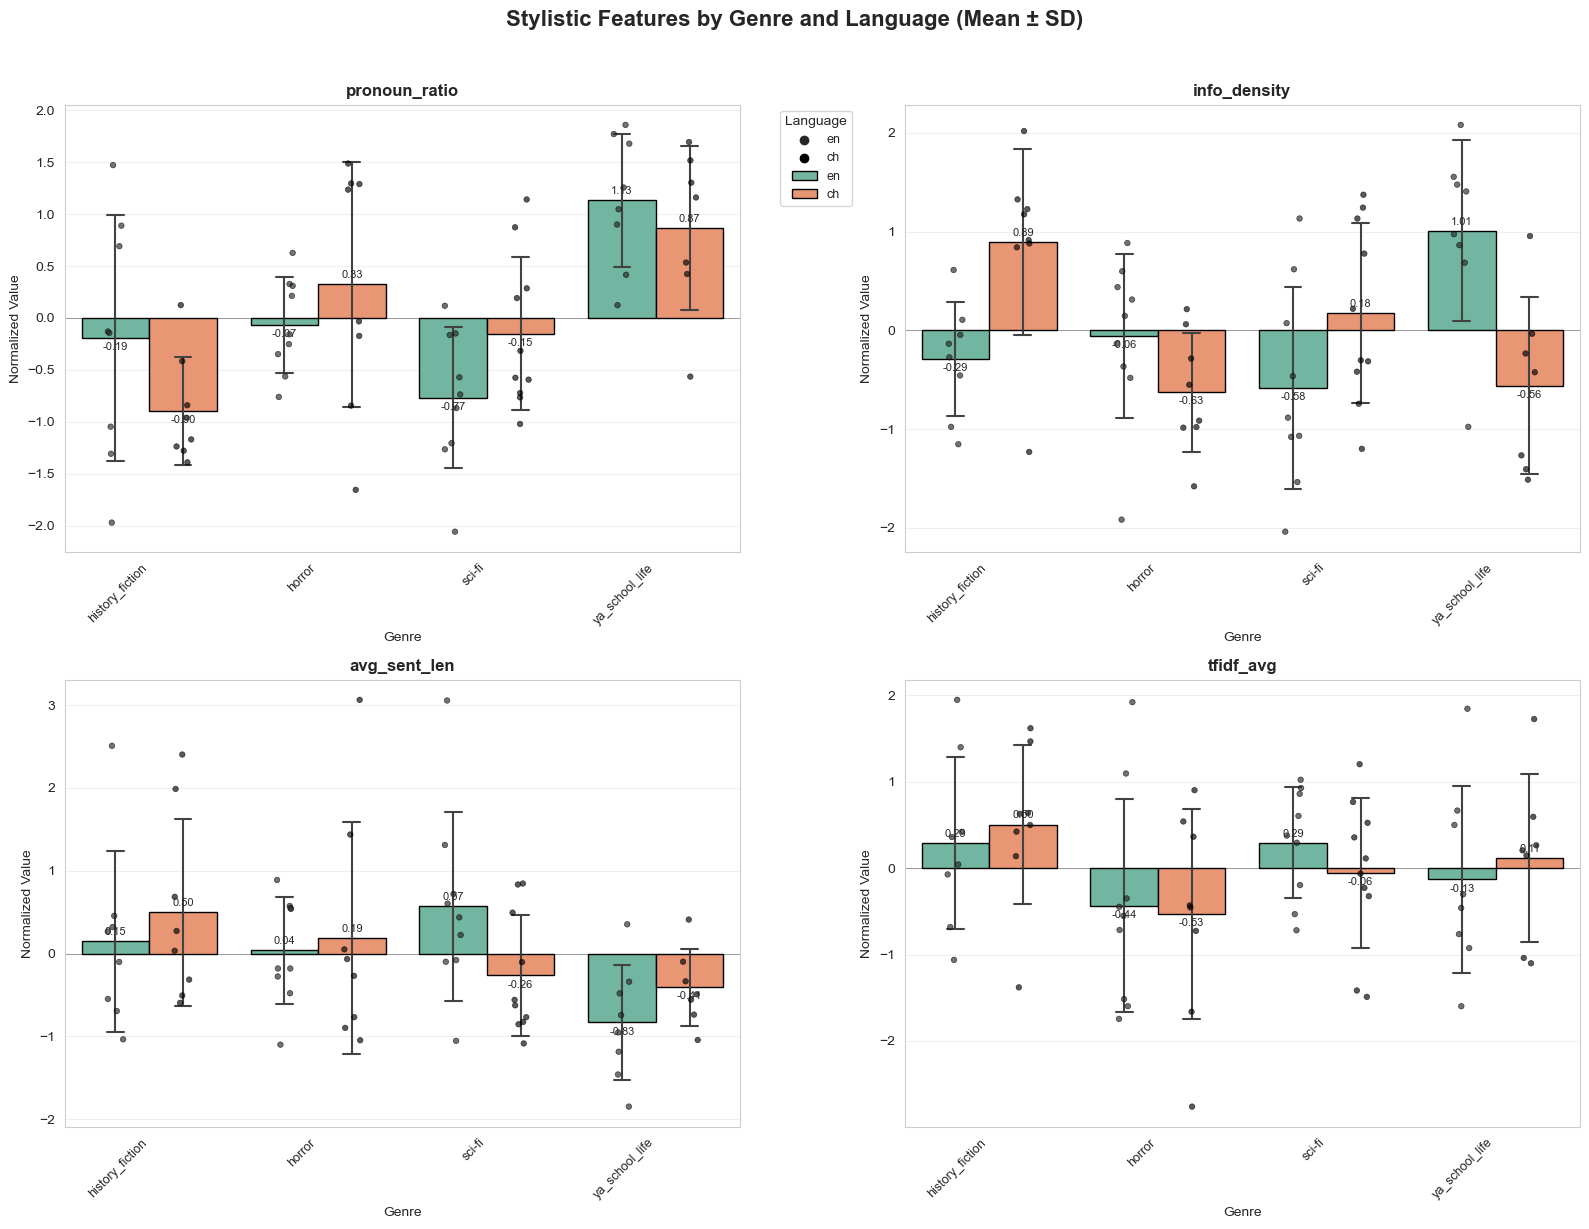

In [ ]:
# Just use this simplified version:
plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    norm_feature = f"{feature}"
    
    # Use seaborn barplot with ci='sd' for standard deviation
    sns.barplot(
        data=df,
        x="genre",
        y=norm_feature,
        hue="language",
        ax=ax,
        ci="sd",  # Standard deviation
        capsize=0.1,
        errwidth=1.5,
        palette="Set2",
        edgecolor='black',
        linewidth=1
    )
    # 2. ADD DOT PLOT — this is the magic!
    sns.stripplot(
        data=df,
        x="genre",
        y=norm_feature,
        hue="language",
        ax=ax,
        dodge=True,                  # separates points by hue (critical!)
        jitter=True,                 # spreads points horizontally
        size=4,                      # dot size
        alpha=0.65,                  # slightly transparent points
        edgecolor="black",
        linewidth=0.5,
        palette="dark:black"         # dark edges for visibility
    )
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)
    
    ax.set_title(f"{feature}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Genre", fontsize=10)
    ax.set_ylabel("Normalized Value", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    if idx == 0:
        ax.legend(title="Language", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    else:
        ax.legend().remove()

fig.suptitle("Stylistic Features by Genre and Language (Mean ± SD)", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Genres sorted by distinctiveness (average |z-score|):
  ya_school_life: 0.631
  history_fiction: 0.464
  sci-fi: 0.357
  horror: 0.283


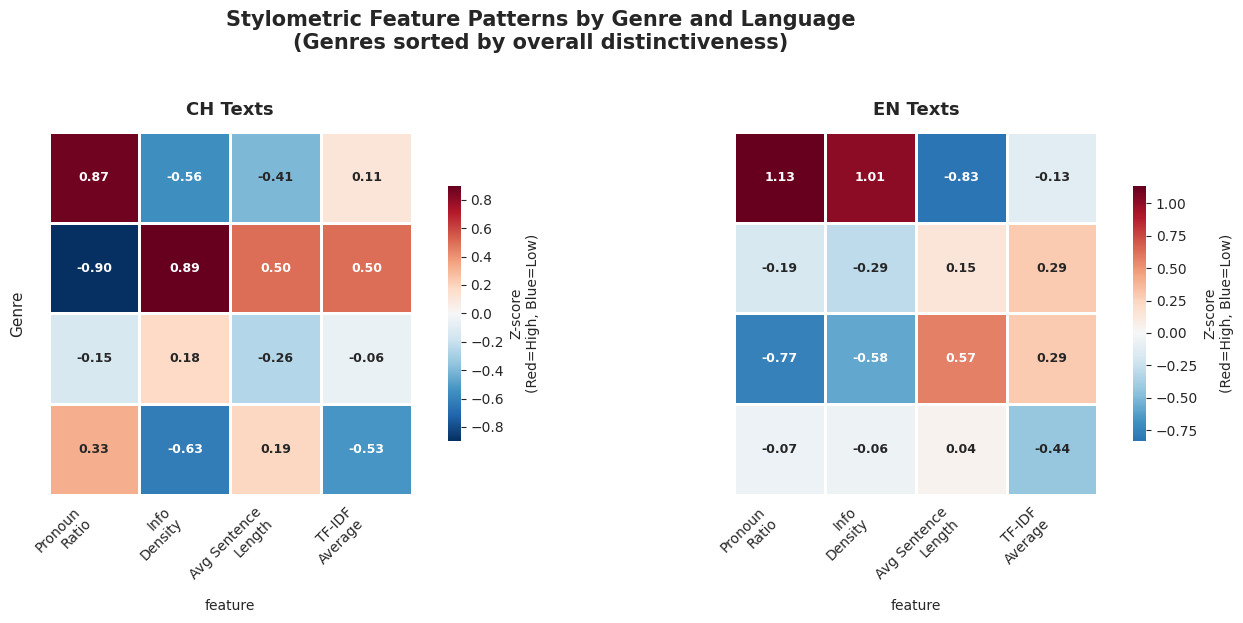

In [ ]:
# Ensure data is prepared
features = ["pronoun_ratio", "info_density", "avg_sent_len", "tfidf_avg"]
df = df.dropna(subset=features + ["genre", "language"]).reset_index(drop=True)

# Normalize features
X = df[features].values

genres = df["genre"].unique()
# Create detailed y-tick labels with distinctiveness score
y_tick_labels = [f"{genre}\n(|z|={genre_avg_z[genre]:.2f})" for genre in genres]


# ────────────────────────
# Compute mean normalized features per genre and language
# ────────────────────────
mean_df = (
    df.groupby(["genre", "language"])[features]
      .mean()
      .reset_index()
)


# Rename columns in mean_df for display
mean_df_display = mean_df.rename(columns=feature)

# Get display feature names
display_features = list(feature.values())

# Get unique languages and genres
languages = sorted(mean_df_display['language'].unique())

# ────────────────────────
# Sort genres by their average z-score across all features
# ────────────────────────

# Calculate average absolute z-score for each genre (across all features and languages)
genre_avg_z = {}
for genre in mean_df_display['genre'].unique():
    genre_data = mean_df_display[mean_df_display['genre'] == genre]
    avg_z = genre_data[display_features].abs().mean().mean()  # Average absolute value
    genre_avg_z[genre] = avg_z

# Sort genres by their average z-score (most distinctive first)
genres = sorted(genre_avg_z.keys(), key=lambda x: genre_avg_z[x], reverse=True)

print("Genres sorted by distinctiveness (average |z-score|):")
for genre in genres:
    print(f"  {genre}: {genre_avg_z[genre]:.3f}")

# ────────────────────────
# Create heatmap with sorted genres
# ────────────────────────

# Prepare data for facet grid
heatmap_data = mean_df_display.melt(id_vars=['genre', 'language'], 
                                     value_vars=display_features,
                                     var_name='feature',
                                     value_name='z_score')

# Create facet grid
g = sns.FacetGrid(heatmap_data, 
                  col='language', 
                  height=6, 
                  aspect=1.2,
                  sharey=True)

# Define plotting function
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    
    # Pivot the data
    pivot_data = data.pivot(index='genre', 
                            columns='feature', 
                            values='z_score')
    
    # Reindex to ensure consistent order - using the sorted 'genres'
    pivot_data = pivot_data.reindex(index=genres, columns=display_features)
    
    # Draw heatmap
    sns.heatmap(pivot_data,
                annot=True,
                fmt=".2f",
                cmap="RdBu_r",
                center=0,
                cbar_kws={'label': 'Z-score\n(Red=High, Blue=Low)', 'shrink': 0.7},
                linewidths=1,
                linecolor='white',
                square=True,
                yticklabels=y_tick_labels,
                annot_kws={'size': 9, 'weight': 'bold'},
                **kwargs)

# Map the plotting function
g.map_dataframe(draw_heatmap)

# Customize titles and labels
for ax, language in zip(g.axes.flat, languages):
    ax.set_title(f"{language.upper()} Texts", fontsize=13, fontweight='bold', pad=12)
    ax.set_ylabel("Genre", fontsize=11, labelpad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

g.fig.suptitle("Stylometric Feature Patterns by Genre and Language\n"
               "(Genres sorted by overall distinctiveness)", 
               fontsize=15, fontweight='bold', y=1.03)

plt.tight_layout()
plt.show()




In [3]:
df = pd.read_csv('df.csv')

In [150]:
df.to_csv('df.csv', index=False) 